# SageMaker PySpark XGBoost MNIST Example

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Loading the Data](#Loading-the-Data)
4. [Training and Hosting a Model](#Training-and-Hosting-a-Model)
5. [Inference](#Inference)
6. [More on SageMaker Spark](#More-on-SageMaker-Spark)


## Introduction
This notebook will show how to classify handwritten digits using the XGBoost algorithm on Amazon SageMaker through the SageMaker PySpark library. We will train on Amazon SageMaker using XGBoost on the MNIST dataset, host the trained model on Amazon SageMaker, and then make predictions against that hosted model.

Unlike the other notebooks that demonstrate XGBoost on Amazon SageMaker, this notebook uses a SparkSession to manipulate data, and uses the SageMaker Spark library to interact with SageMaker with Spark Estimators and Transformers.

You can visit SageMaker Spark's GitHub repository at https://github.com/aws/sagemaker-spark to learn more about SageMaker Spark.

You can visit XGBoost's GitHub repository at https://github.com/dmlc/xgboost to learn more about XGBoost

This notebook was created and tested on an ml.m4.xlarge notebook instance.

## Setup

First, we import the necessary modules and create the SparkSession with the SageMaker Spark dependencies.

In [2]:
import os

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

## Loading the Data

Now, we load the MNIST dataset into a Spark Dataframe, which dataset is available in LibSVM format at

`s3://sagemaker-sample-data-[region]/spark/mnist/train/`

where `[region]` is replaced with a supported AWS region, such as us-east-1.

In order to train and make inferences our input DataFrame must have a column of Doubles (named "label" by default) and a column of Vectors of Doubles (named "features" by default).

Spark's LibSVM DataFrameReader loads a DataFrame already suitable for training and inference.

Here, we load into a DataFrame in the SparkSession running on the local Notebook Instance, but you can connect your Notebook Instance to a remote Spark cluster for heavier workloads. Starting from EMR 5.11.0, SageMaker Spark is pre-installed on EMR Spark clusters. For more on connecting your SageMaker Notebook Instance to a remote EMR cluster, please see [this blog post](https://aws.amazon.com/blogs/machine-learning/build-amazon-sagemaker-notebooks-backed-by-spark-in-amazon-emr/).

In [3]:
import boto3

cn_regions = ['cn-north-1', 'cn-northwest-1']
region = boto3.Session().region_name
endpoint_domain = 'com.cn' if region in cn_regions else 'com'
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.{}'.format(region, endpoint_domain))

trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .option('vectorType', 'dense')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .option('vectorType', 'dense')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,0.0,0.0,0.0,...|
|  4.0|[0.0,0.0,0.0,0.0,...|
|  1.0|[0.0,0.0,0.0,0.0,...|
|  9.0|[0.0,0.0,0.0,0.0,...|
|  2.0|[0.0,0.0,0.0,0.0,...|
|  1.0|[0.0,0.0,0.0,0.0,...|
|  3.0|[0.0,0.0,0.0,0.0,...|
|  1.0|[0.0,0.0,0.0,0.0,...|
|  4.0|[0.0,0.0,0.0,0.0,...|
|  3.0|[0.0,0.0,0.0,0.0,...|
|  5.0|[0.0,0.0,0.0,0.0,...|
|  3.0|[0.0,0.0,0.0,0.0,...|
|  6.0|[0.0,0.0,0.0,0.0,...|
|  1.0|[0.0,0.0,0.0,0.0,...|
|  7.0|[0.0,0.0,0.0,0.0,...|
|  2.0|[0.0,0.0,0.0,0.0,...|
|  8.0|[0.0,0.0,0.0,0.0,...|
|  6.0|[0.0,0.0,0.0,0.0,...|
|  9.0|[0.0,0.0,0.0,0.0,...|
+-----+--------------------+
only showing top 20 rows



## Training and Hosting a Model
Now we create an XGBoostSageMakerEstimator, which uses the XGBoost Amazon SageMaker Algorithm to train on our input data, and uses the XGBoost Amazon SageMaker model image to host our model.

Calling fit() on this estimator will train our model on Amazon SageMaker, and then create an Amazon SageMaker Endpoint to host our model.

We can then use the SageMakerModel returned by this call to fit() to transform Dataframes using our hosted model.

The following cell runs a training job and creates an endpoint to host the resulting model, so this cell can take up to twenty minutes to complete.

In [4]:
import random
from sagemaker_pyspark import IAMRole, S3DataPath
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator

xgboost_estimator = XGBoostSageMakerEstimator(
    sagemakerRole=IAMRole(role),
    trainingInstanceType='ml.m5.4xlarge',
    trainingInstanceCount=1,
    endpointInstanceType='ml.m4.xlarge',
    endpointInitialInstanceCount=1)

xgboost_estimator.setEta(0.2)
xgboost_estimator.setGamma(4)
xgboost_estimator.setMinChildWeight(6)
xgboost_estimator.setSilent(0)
xgboost_estimator.setObjective("multi:softmax")
xgboost_estimator.setNumClasses(10)
xgboost_estimator.setNumRound(10)

# train
model = xgboost_estimator.fit(trainingData)

## Inference
Now we transform our DataFrame.
To do this, we serialize each row's "features" Vector of Doubles into LibSVM format for inference against the Amazon SageMaker Endpoint. We deserialize the CSV responses from the XGBoost model back into our DataFrame. This serialization and deserialization is handled automatically by the `transform()` method:

In [5]:
transformedData = model.transform(testData)

transformedData.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  7.0|[0.0,0.0,0.0,0.0,...|       7.0|
|  2.0|[0.0,0.0,0.0,0.0,...|       2.0|
|  1.0|[0.0,0.0,0.0,0.0,...|       1.0|
|  0.0|[0.0,0.0,0.0,0.0,...|       0.0|
|  4.0|[0.0,0.0,0.0,0.0,...|       4.0|
|  1.0|[0.0,0.0,0.0,0.0,...|       1.0|
|  4.0|[0.0,0.0,0.0,0.0,...|       4.0|
|  9.0|[0.0,0.0,0.0,0.0,...|       9.0|
|  5.0|[0.0,0.0,0.0,0.0,...|       5.0|
|  9.0|[0.0,0.0,0.0,0.0,...|       9.0|
|  0.0|[0.0,0.0,0.0,0.0,...|       0.0|
|  6.0|[0.0,0.0,0.0,0.0,...|       6.0|
|  9.0|[0.0,0.0,0.0,0.0,...|       9.0|
|  0.0|[0.0,0.0,0.0,0.0,...|       0.0|
|  1.0|[0.0,0.0,0.0,0.0,...|       1.0|
|  5.0|[0.0,0.0,0.0,0.0,...|       5.0|
|  9.0|[0.0,0.0,0.0,0.0,...|       9.0|
|  7.0|[0.0,0.0,0.0,0.0,...|       7.0|
|  3.0|[0.0,0.0,0.0,0.0,...|       3.0|
|  4.0|[0.0,0.0,0.0,0.0,...|       4.0|
+-----+--------------------+----------+
only showing top 20 rows



How well did the algorithm perform? Let us display the digits corresponding to each of the labels and manually inspect the results:




Cluster 0:


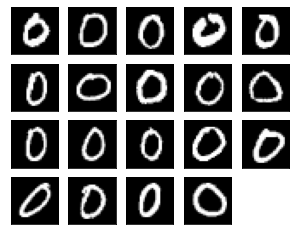




Cluster 1:


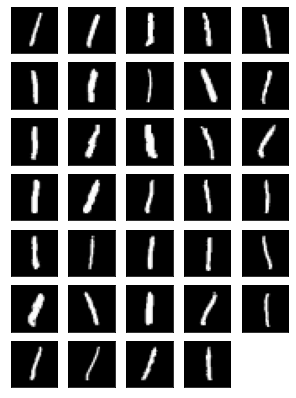




Cluster 2:


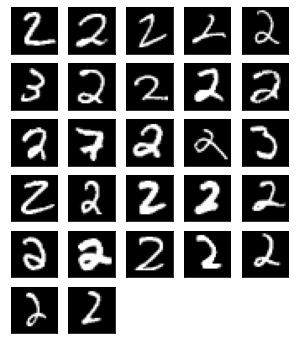




Cluster 3:


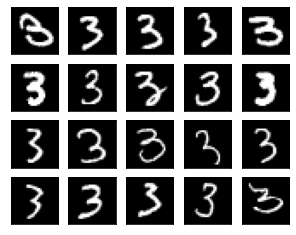




Cluster 4:


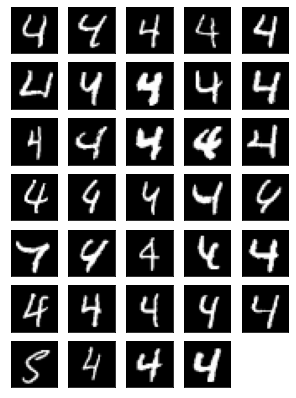




Cluster 5:


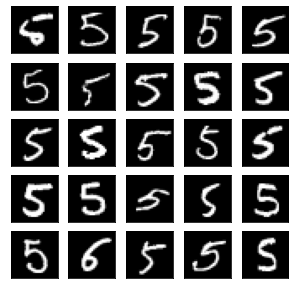




Cluster 6:


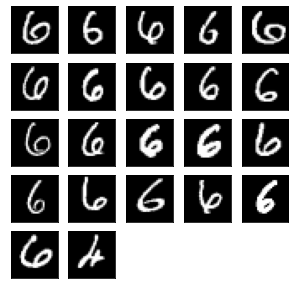




Cluster 7:


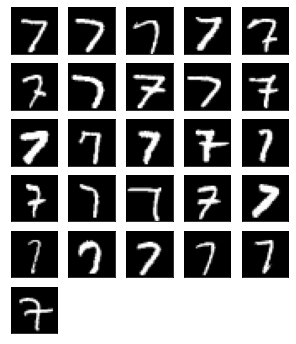




Cluster 8:


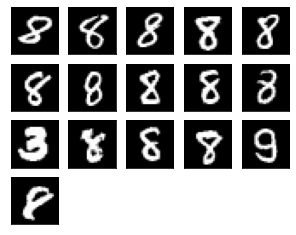




Cluster 9:


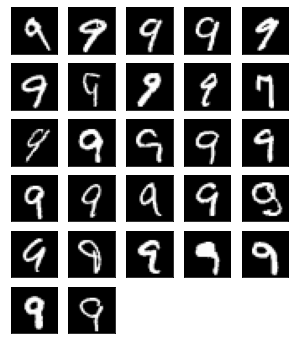

In [6]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np

# helper function to display a digit
def show_digit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')

images = np.array(transformedData.select("features").cache().take(250))
clusters = transformedData.select("prediction").cache().take(250)

for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits=[ img for l, img in zip(clusters, images) if int(l.prediction) == cluster ]
    height=((len(digits) - 1) // 5) + 1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=np.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

Since we don't need to make any more inferences, now we delete the endpoint:

In [ ]:
# Delete the endpoint

from sagemaker_pyspark import SageMakerResourceCleanup

resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
resource_cleanup.deleteResources(model.getCreatedResources())

## More on SageMaker Spark

The SageMaker Spark Github repository has more about SageMaker Spark, including how to use SageMaker Spark with your own algorithms on Amazon SageMaker: https://github.com/aws/sagemaker-spark
